In [2]:
# 1. Data Exploration and Preprocessing
# First, thoroughly understand your data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your datasets
bac_results = pd.read_csv("enhanced_bac_results.csv")
ml_features = pd.read_csv("ml_training_features.csv")
ml_processed = pd.read_csv("ml_processed_features.csv")  # If already created

# Examine data shape and structure
print(f"BAC Results shape: {bac_results.shape}")
print(f"ML Features shape: {ml_features.shape}")

# Check class distribution
attack_count = ml_features['attack_detected'].sum()
total = len(ml_features)
print(f"Normal requests: {total - attack_count} ({(total - attack_count) / total:.2%})")
print(f"Attack requests: {attack_count} ({attack_count / total:.2%})")

C:\Users\aashm\AppData\Local\Temp\ipykernel_21188\2484237503.py:11: DtypeWarning: Columns (10,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  ml_processed = pd.read_csv("ml_processed_features.csv")  # If already created


BAC Results shape: (1000000, 24)
ML Features shape: (1000000, 20)
Normal requests: 828691 (82.87%)
Attack requests: 171309 (17.13%)


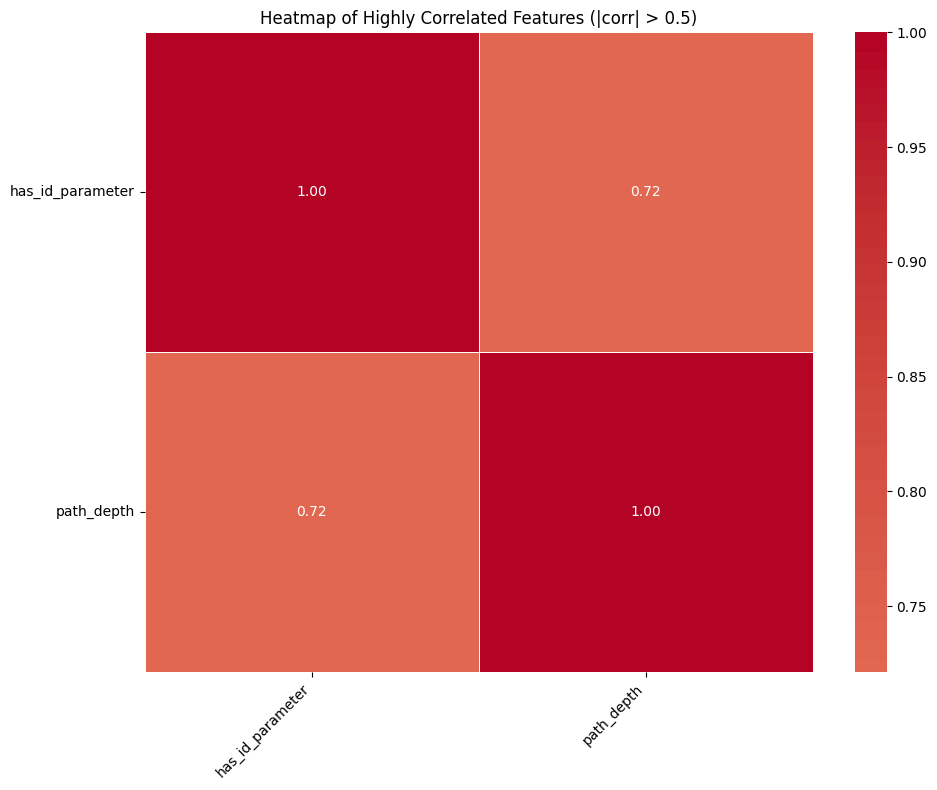

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute correlation matrix
corr_matrix = ml_processed.drop(['attack_detected', 'user_id'], axis=1).corr()

# Step 2: Find highly correlated pairs (|correlation| > 0.8 but < 1)
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]  # exclude self-correlation
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.6]
high_corr_pairs = high_corr_pairs[~high_corr_pairs.index.duplicated()]  # remove duplicate pairs

# Step 3: Get unique features involved
high_corr_features = set()
for i, j in high_corr_pairs.index:
    high_corr_features.add(i)
    high_corr_features.add(j)

# Step 4: Filter the correlation matrix
filtered_features = sorted(list(high_corr_features))
filtered_corr_matrix = corr_matrix.loc[filtered_features, filtered_features]

# Step 5: Plot the filtered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title("Heatmap of Highly Correlated Features (|corr| > 0.5)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [4]:
# 2. Feature Engineering
# Enhance your features to improve model performance:

from sklearn.preprocessing import StandardScaler
import numpy as np
import json

# Load behavioral data for additional features
with open('user_behavior_profiles.json', 'r') as f:
    user_profiles = json.load(f)

with open('resource_access_patterns.json', 'r') as f:
    resource_patterns = json.load(f)

# Add deviation from normal behavior features
def calculate_behavioral_anomaly(row):
    user_id = str(row['user_id'])
    if user_id not in user_profiles:
        return 0.5  # Default for unknown users
    
    # Calculate deviation from user's typical hour pattern
    hour = row['hour_of_day']
    typical_hour_freq = user_profiles[user_id]['hour_distribution'][hour]
    hour_anomaly = 1 - typical_hour_freq if typical_hour_freq > 0 else 1
    
    # More behavioral features can be added based on profiles
    return hour_anomaly

# Apply to dataframe
ml_processed['behavioral_anomaly'] = ml_processed.apply(calculate_behavioral_anomaly, axis=1)

# Create temporal features
ml_processed['request_rate'] = ml_processed['requests_last_hour'] / 60  # Requests per minute

# Scale numerical features
numerical_features = ['recent_failures', 'requests_last_hour', 'avg_request_time', 
                      'resource_popularity', 'sequence_anomaly_score', 'behavioral_anomaly']
scaler = StandardScaler()
ml_processed[numerical_features] = scaler.fit_transform(ml_processed[numerical_features])

# Save the enhanced dataset
ml_processed.to_csv('ml_enhanced_features.csv', index=False)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Prepare data
X = ml_processed.drop(['attack_detected', 'user_id'], axis=1)
y = ml_processed['attack_detected']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Storage
trained_models = {}
metrics_list = []

# Train and evaluate
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store model and overall metrics
    trained_models[name] = model
    metrics_list.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4),
        'Recall (macro)': round(report['macro avg']['recall'], 4),
        'F1-score (macro)': round(report['macro avg']['f1-score'], 4)
    })

# Display as table
results_df = pd.DataFrame(metrics_list)
results_df.set_index('Model', inplace=True)
display(results_df)


ValueError: Input y contains NaN.

In [45]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForest only
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

best_models = {}

# Assuming 'models' dictionary is already defined and contains 'RandomForest'
model = models['RandomForest']
print("Tuning RandomForest...")

grid = GridSearchCV(
    model,
    param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_resampled, y_train_resampled)

best_models['RandomForest'] = grid.best_estimator_

print(f"Best params for RandomForest: {grid.best_params_}")
print(f"Best AUC on validation set: {grid.best_score_:.4f}")
print("-----")


Tuning RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on validation set: 0.9680
-----


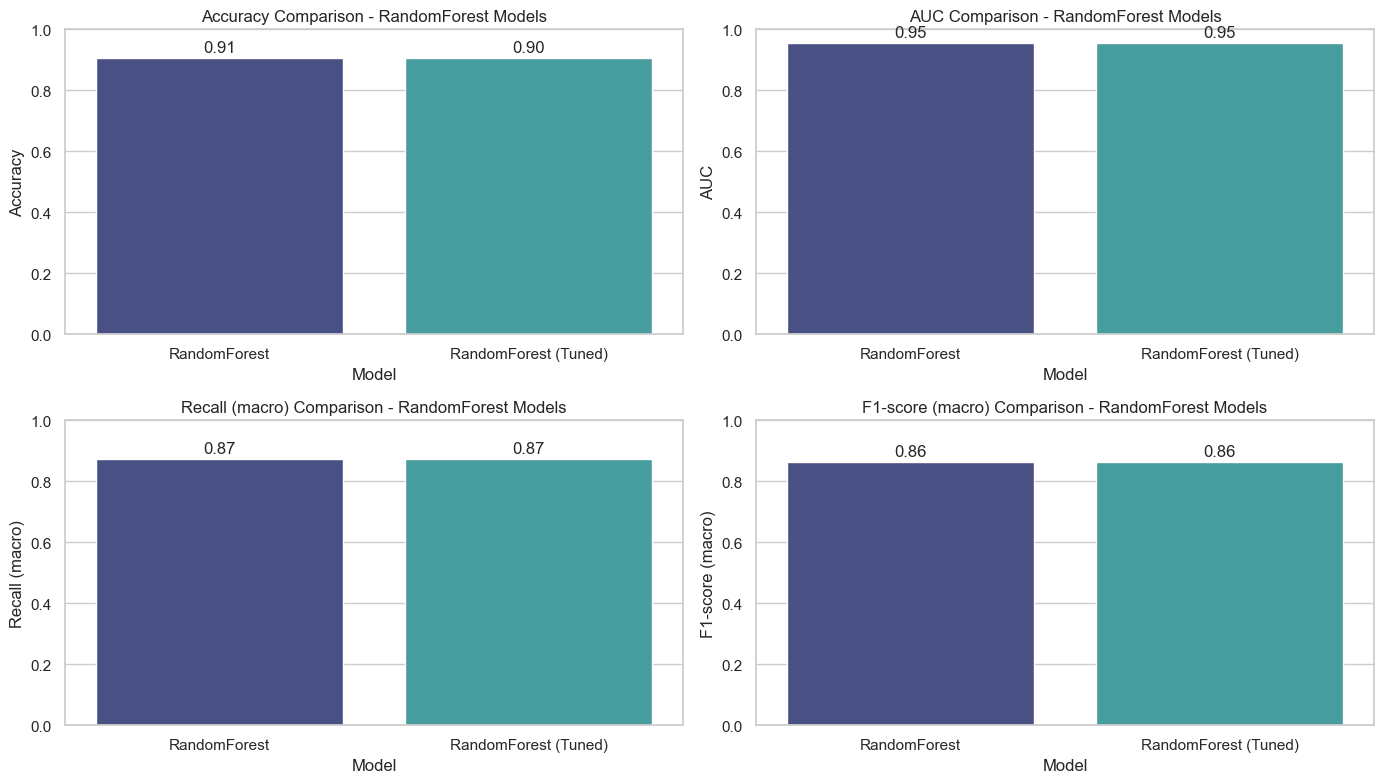

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for only RandomForest and RandomForest (Tuned)
filtered_df = results_df.loc[results_df.index.isin(['RandomForest', 'RandomForest (Tuned)'])].reset_index()

# Set plot style
sns.set(style="whitegrid")
metrics_to_plot = ['Accuracy', 'AUC', 'Recall (macro)', 'F1-score (macro)']

# Create a subplot for each metric
plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=filtered_df, x='Model', y=metric, palette='mako')
    plt.title(f'{metric} Comparison - RandomForest Models')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    for index, value in enumerate(filtered_df[metric]):
        plt.text(index, value + 0.01, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


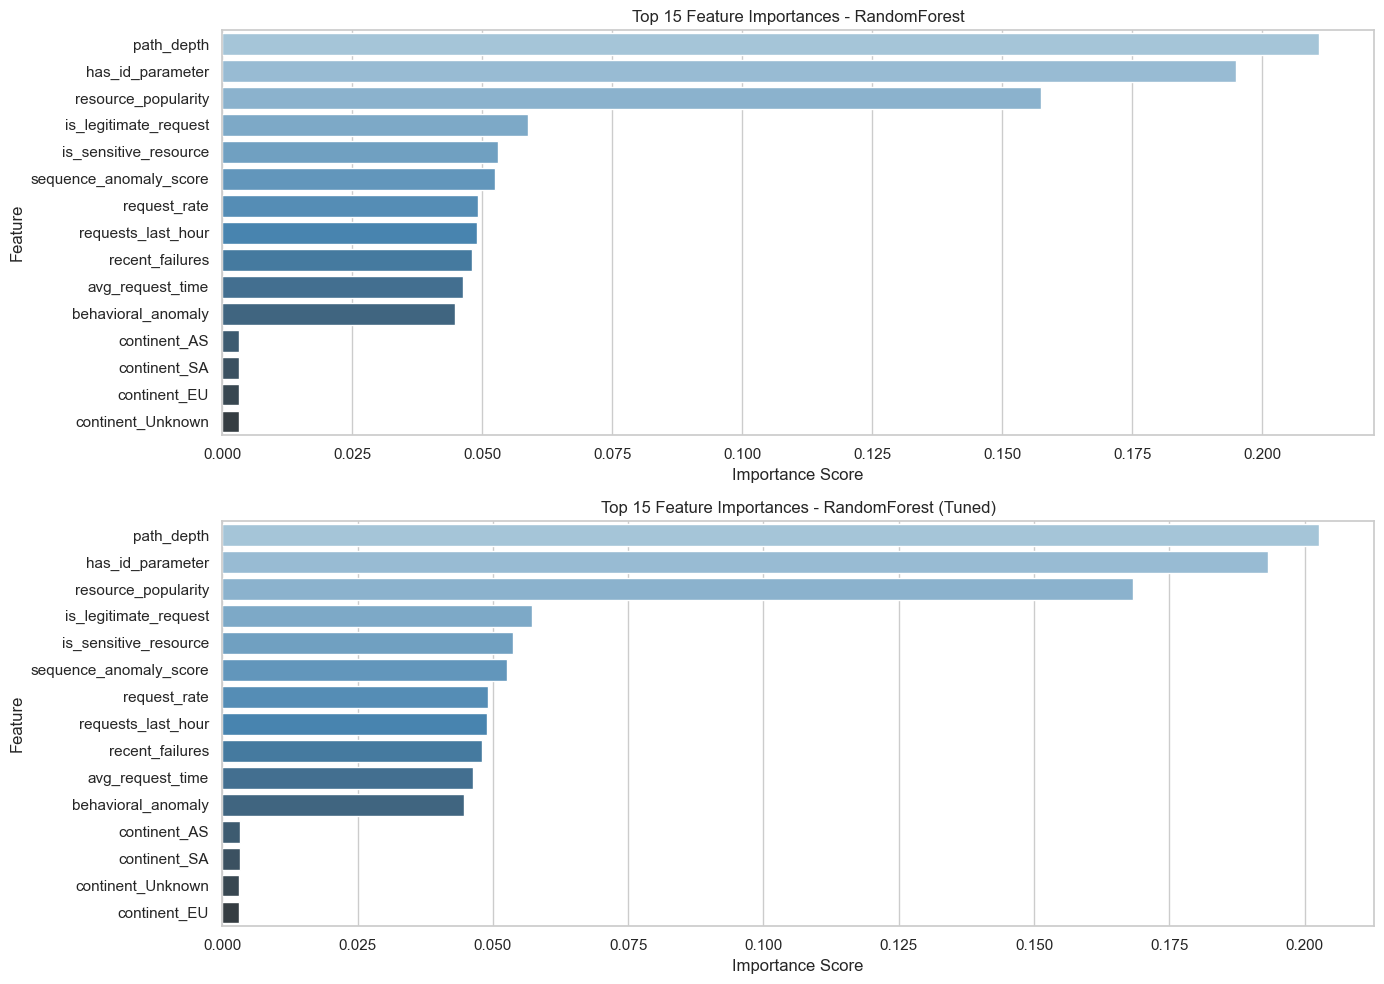

In [48]:
importances_df = {}

# Number of top features to show
top_n = 15

# Filter for only RandomForest models
for name in ['RandomForest', 'RandomForest (Tuned)']:
    model = trained_models.get(name)
    if model and hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(top_n)
        importances_df[name] = df

# Plotting
plt.figure(figsize=(14, 10))
for i, (model_name, imp_df) in enumerate(importances_df.items(), 1):
    plt.subplot(2, 1, i)
    sns.barplot(data=imp_df, x='Importance', y='Feature', palette='Blues_d')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")

plt.tight_layout()
plt.show()




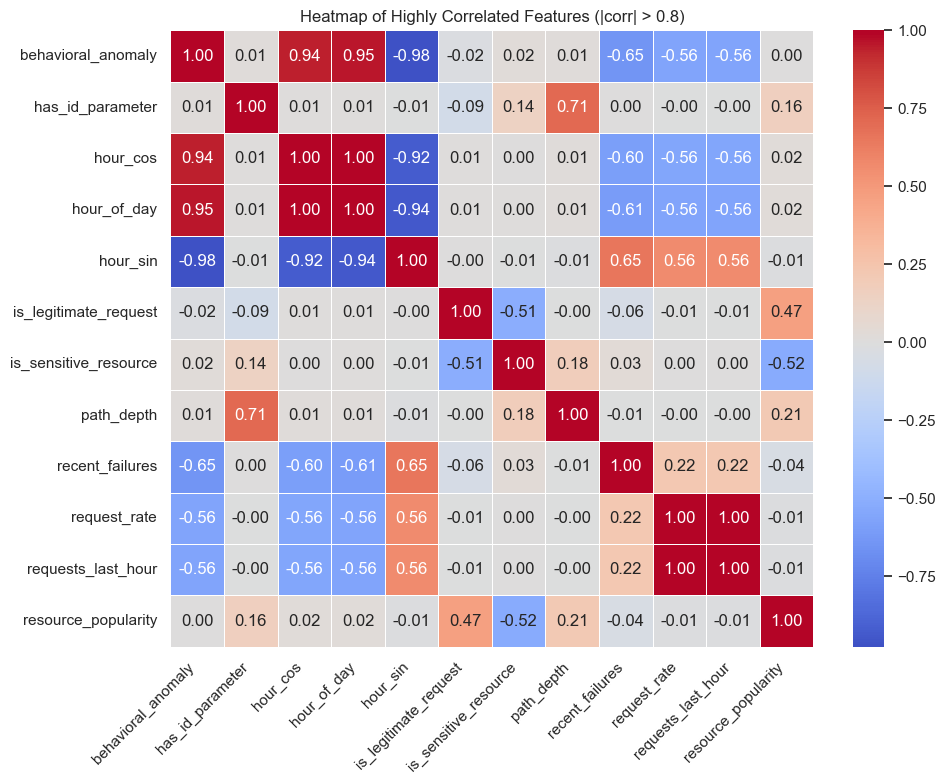

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94    157216
           1       0.76      0.82      0.79     42784

    accuracy                           0.91    200000
   macro avg       0.85      0.87      0.86    200000
weighted avg       0.91      0.91      0.91    200000

Tuned Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94    157216
           1       0.76      0.82      0.79     42784

    accuracy                           0.90    200000
   macro avg       0.85      0.87      0.86    200000
weighted avg       0.91      0.90      0.91    200000



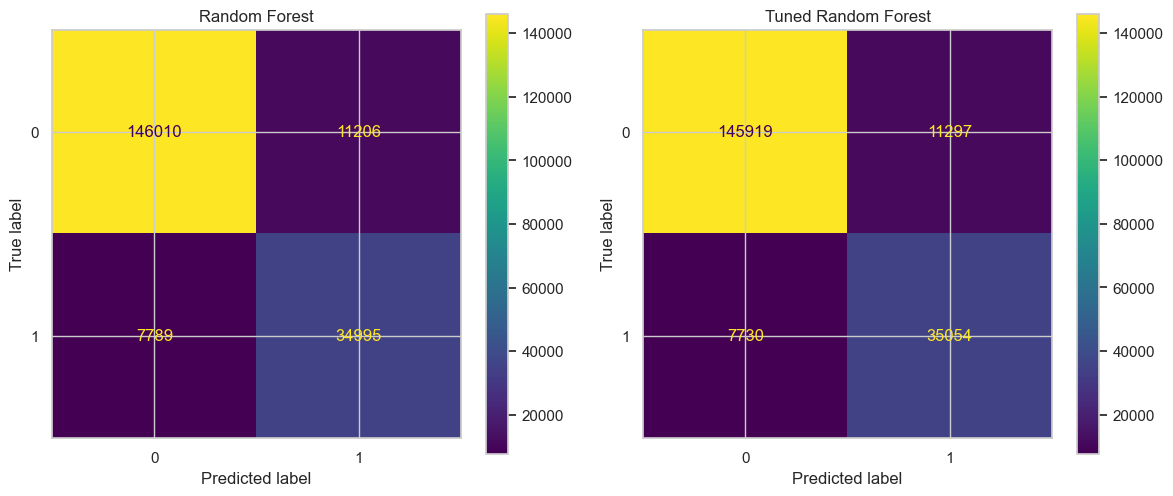

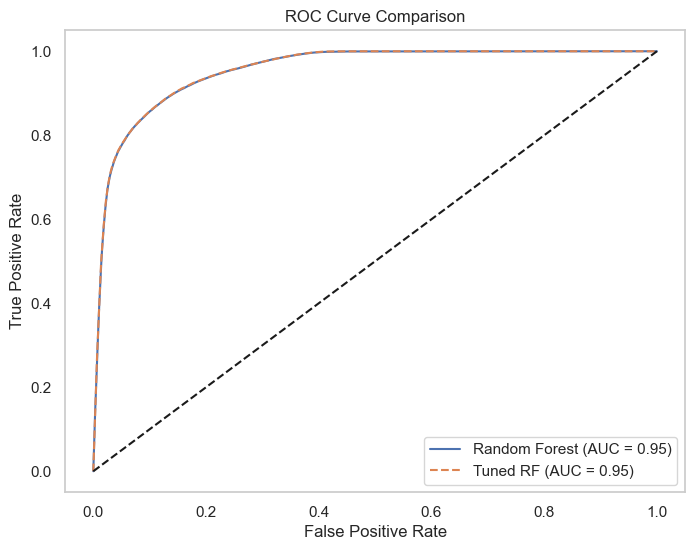

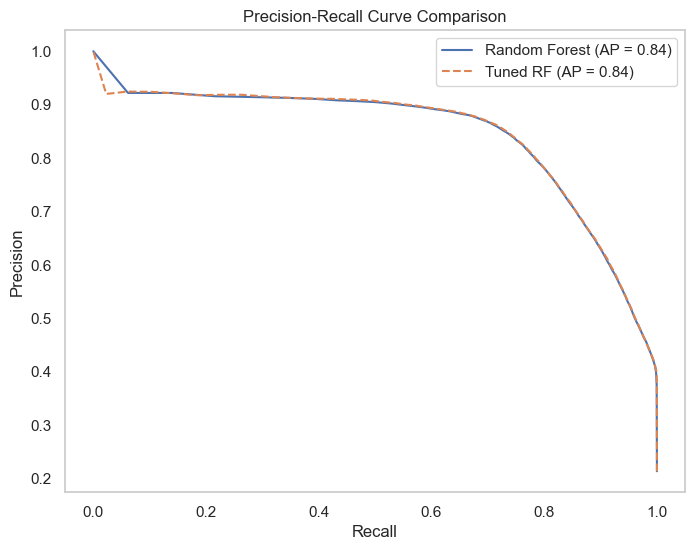

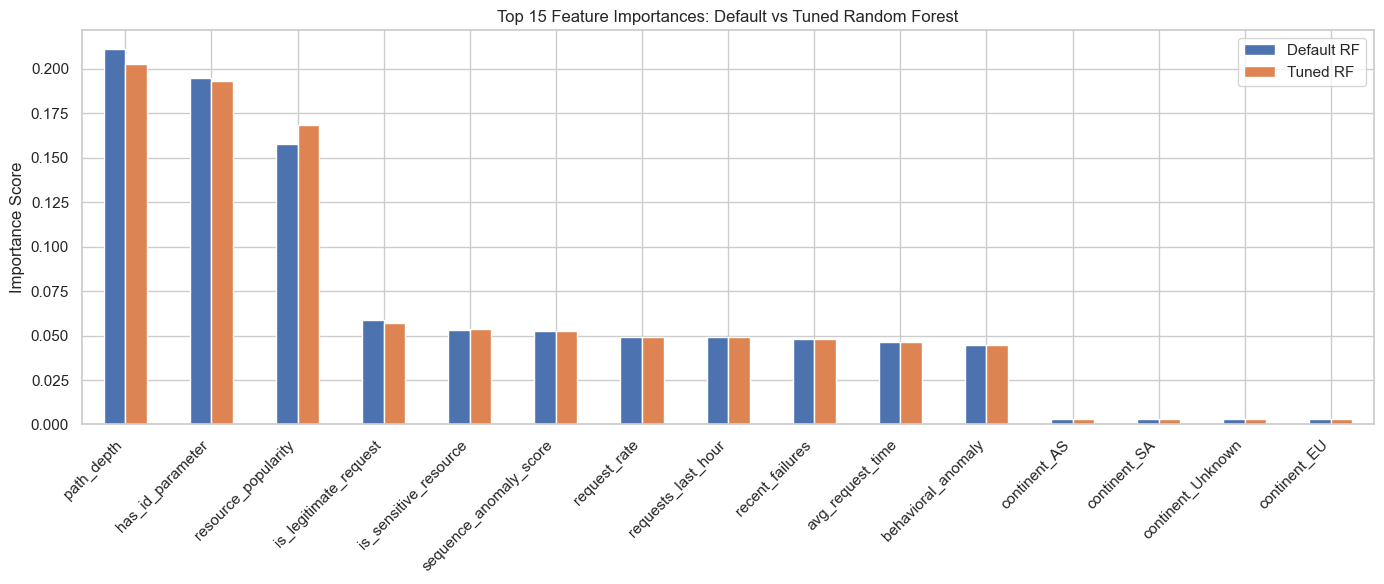

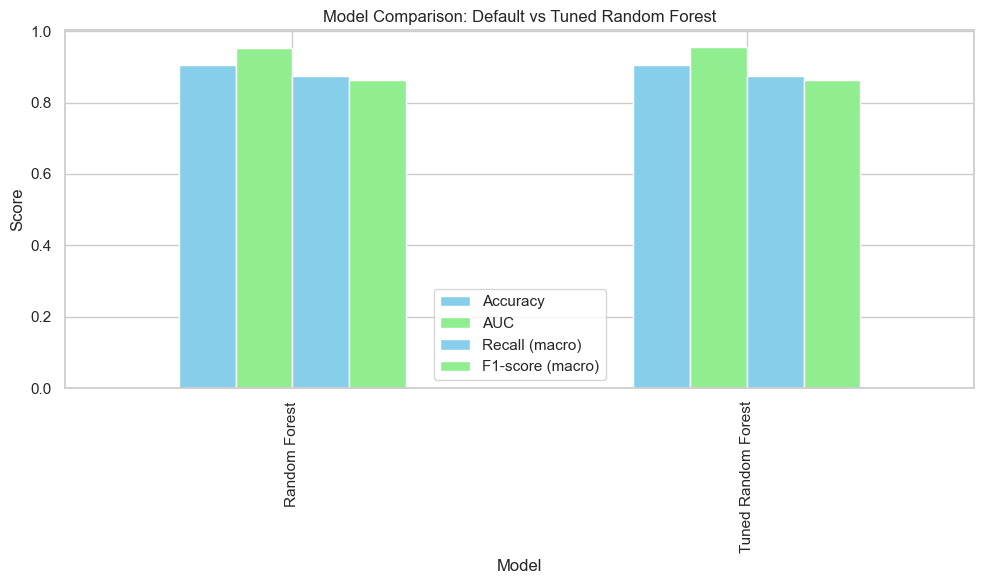

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, roc_curve, roc_auc_score,
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
)
import pandas as pd

# Make sure both models exist
rf_model = trained_models['RandomForest']
tuned_rf_model = trained_models['RandomForest (Tuned)']

# Get predictions and probabilities
rf_preds = rf_model.predict(X_test)
tuned_preds = tuned_rf_model.predict(X_test)

# Get predicted probabilities
rf_probs = rf_model.predict_proba(X_test)[:, 1]
tuned_probs = tuned_rf_model.predict_proba(X_test)[:, 1]

# --- 1. Classification Report ---
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds))

print("Tuned Random Forest Classification Report:\n")
print(classification_report(y_test, tuned_preds))

# --- 2. Confusion Matrix ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axes[0])
axes[0].set_title("Random Forest")

ConfusionMatrixDisplay.from_estimator(tuned_rf_model, X_test, y_test, ax=axes[1])
axes[1].set_title("Tuned Random Forest")

plt.tight_layout()
plt.show()

# --- 3. ROC Curve ---
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, tuned_probs)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})')
plt.plot(tuned_fpr, tuned_tpr, label=f'Tuned RF (AUC = {roc_auc_score(y_test, tuned_probs):.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# --- 4. Precision-Recall Curve ---
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
tuned_precision, tuned_recall, _ = precision_recall_curve(y_test, tuned_probs)

plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {average_precision_score(y_test, rf_probs):.2f})')
plt.plot(tuned_recall, tuned_precision, label=f'Tuned RF (AP = {average_precision_score(y_test, tuned_probs):.2f})', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# --- 5. Feature Importance Comparison ---
default_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
tuned_importance = pd.Series(tuned_rf_model.feature_importances_, index=X_train.columns)

# Combine and compare feature importances
comparison_df = pd.DataFrame({
    'Default RF': default_importance,
    'Tuned RF': tuned_importance
}).sort_values('Tuned RF', ascending=False).head(15)

# Plot comparison of feature importance
comparison_df.plot(kind='bar', figsize=(14, 6))
plt.title("Top 15 Feature Importances: Default vs Tuned Random Forest")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 6. Model Metrics Comparison ---
metrics_list = []

# Collect metrics for both models
metrics_list.append({
    'Model': 'Random Forest',
    'Accuracy': round(rf_model.score(X_test, y_test), 4),
    'AUC': round(roc_auc_score(y_test, rf_probs), 4),
    'Recall (macro)': round(classification_report(y_test, rf_preds, output_dict=True)['macro avg']['recall'], 4),
    'F1-score (macro)': round(classification_report(y_test, rf_preds, output_dict=True)['macro avg']['f1-score'], 4)
})

metrics_list.append({
    'Model': 'Tuned Random Forest',
    'Accuracy': round(tuned_rf_model.score(X_test, y_test), 4),
    'AUC': round(roc_auc_score(y_test, tuned_probs), 4),
    'Recall (macro)': round(classification_report(y_test, tuned_preds, output_dict=True)['macro avg']['recall'], 4),
    'F1-score (macro)': round(classification_report(y_test, tuned_preds, output_dict=True)['macro avg']['f1-score'], 4)
})

# Convert metrics list to DataFrame and plot
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

# Plot performance metrics comparison
metrics_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title("Model Comparison: Default vs Tuned Random Forest")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [51]:
import joblib
joblib.dump(trained_models['RandomForest'], 'primary_rf_model.pkl')
joblib.dump(trained_models['RandomForest'], 'secondary_rft_model.pkl')


['secondary_rft_model.pkl']

In [ ]:
# 6. Build a Real-Time Detection System
# Create a service to process requests in real-time

import pandas as pd
import numpy as np
import pickle
import json
from flask import Flask, request, jsonify
import time
from datetime import datetime
import threading
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("bac_detector.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("BAC-Detector")

app = Flask(__name__)

# Load the ML model
with open('bac_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load the feature scaler
with open('feature_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load behavior profiles
with open('user_behavior_profiles.json', 'r') as f:
    user_profiles = json.load(f)

# Load resource patterns
with open('resource_access_patterns.json', 'r') as f:
    resource_patterns = json.load(f)

# In-memory databases for real-time tracking
user_session_data = {}  # User activity tracking
recent_requests = []    # For rate limiting
anomaly_cache = {}      # Store recent anomaly scores
alert_history = []      # Recent alerts

# Constants
TIME_WINDOWS = {
    "short": 5 * 60,    # 5 minutes in seconds
    "medium": 30 * 60,  # 30 minutes 
    "long": 24 * 60 * 60  # 24 hours
}

# Thread lock for shared data structures
data_lock = threading.Lock()

def extract_resource_type(url):
    """Extract resource type from URL path"""
    parts = url.split('/')
    if len(parts) >= 3:
        return parts[2]
    return "unknown"

def calculate_behavioral_features(user_id, resource, hour_of_day):
    """Calculate behavioral anomaly features"""
    features = {}
    user_id = str(user_id)
    
    # User profile features
    if user_id in user_profiles:
        profile = user_profiles[user_id]
        
        # Time-based anomaly
        hour_distribution = profile.get('hour_distribution', [0] * 24)
        typical_hour_freq = hour_distribution[hour_of_day] if hour_of_day < len(hour_distribution) else 0
        features['hour_anomaly'] = 1 - typical_hour_freq if typical_hour_freq > 0 else 1
        
        # Resource access anomaly
        resource_distribution = profile.get('resource_distribution', {})
        resource_freq = resource_distribution.get(resource, 0)
        features['resource_anomaly'] = 1 - resource_freq if resource_freq > 0 else 1
        
        # Error rate baseline
        features['baseline_error_rate'] = profile.get('error_rate', 0.05)
        
    else:
        # Default values for unknown users
        features['hour_anomaly'] = 0.5
        features['resource_anomaly'] = 0.5
        features['baseline_error_rate'] = 0.05
    
    # Resource popularity from global patterns
    resource_popularity = 0.01  # Default value
    if hasattr(resource_patterns, 'get'):
        global_popularity = resource_patterns.get('global_popularity', {})
        resource_popularity = global_popularity.get(resource, 0.01)
    
    features['resource_popularity'] = resource_popularity
    
    return features

def calculate_sequence_anomaly(user_id):
    """Analyze user's recent activity for suspicious patterns"""
    with data_lock:
        if user_id not in user_session_data:
            return 0.0
            
        recent_activity = user_session_data[user_id]
        
        # Not enough data
        if len(recent_activity) < 3:
            return 0.0
    
    # Calculate time between requests
    timestamps = [entry['timestamp'] for entry in recent_activity]
    time_diffs = []
    for i in range(1, len(timestamps)):
        time_diffs.append(timestamps[i] - timestamps[i-1])
    
    # Very fast sequences are suspicious
    if time_diffs and min(time_diffs) < 0.5:  # Less than 0.5 seconds between requests
        return 0.8
        
    # Calculate failure rate
    status_codes = [entry['status_code'] for entry in recent_activity]
    failure_count = sum(1 for code in status_codes if code >= 400)
    failure_rate = failure_count / len(status_codes)
    
    # High failure rate is suspicious
    if failure_rate > 0.5 and len(status_codes) >= 3:
        return 0.7
        
    # Method variety
    methods = [entry['method'] for entry in recent_activity]
    unique_methods = len(set(methods))
    if unique_methods >= 3 and len(methods) <= 5:  # Many different methods in a short sequence
        return 0.6
        
    # Resource variety (potential scanning)
    resources = [entry['resource'] for entry in recent_activity]
    unique_resources = len(set(resources))
    if unique_resources >= 4 and len(resources) <= 6:  # Many different resources quickly
        return 0.65
    
    return 0.1  # Default low anomaly

def prepare_real_time_features(request_data):
    """Extract and prepare features for real-time prediction"""
    # Current time info
    current_time = datetime.now()
    hour_of_day = current_time.hour
    day_of_week = current_time.weekday()
    is_weekend = 1 if day_of_week >= 5 else 0
    is_business_hours = 1 if 9 <= hour_of_day <= 17 and not is_weekend else 0
    
    # Extract request info
    user_id = request_data.get('user_id', 0)
    url = request_data.get('url', '')
    method = request_data.get('method', 'GET')
    auth_method = request_data.get('auth_method', 'None')
    token_validity = request_data.get('token_validity', 'Valid')
    resource_type = extract_resource_type(url)
    is_sensitive = 1 if request_data.get('sensitivity', '') == 'high' else 0
    
    # Get user location info
    geo_continent = request_data.get('geo_data', {}).get('continent', 'Unknown')
    geo_country = request_data.get('geo_data', {}).get('country', 'Unknown')
    
    # Calculate behavioral features
    behavioral_features = calculate_behavioral_features(user_id, resource_type, hour_of_day)
    
    # Calculate request timing features
    current_timestamp = time.time()
    
    with data_lock:
        # Count recent requests by this user
        recent_count = 0
        recent_failures = 0
        
        if user_id in user_session_data:
            user_history = user_session_data[user_id]
            
            # Count requests in short window
            recent_count = sum(1 for entry in user_history 
                              if current_timestamp - entry['timestamp'] < TIME_WINDOWS['short'])
                              
            # Count failures
            recent_failures = sum(1 for entry in user_history 
                                if entry['status_code'] >= 400 and 
                                current_timestamp - entry['timestamp'] < TIME_WINDOWS['short'])
        
        # Calculate request rate (requests per minute)
        request_rate = recent_count / 5.0  # Convert to per minute (5 min window)
        
    # Calculate sequence anomaly
    sequence_anomaly = calculate_sequence_anomaly(user_id)
    
    # Assemble feature dictionary (match your trained model's features)
    features = {
        'hour_of_day': hour_of_day,
        'day_of_week': day_of_week,
        'is_weekend': is_weekend,
        'is_business_hours': is_business_hours,
        'recent_failures': recent_failures,
        'requests_last_hour': recent_count,
        'resource_popularity': behavioral_features['resource_popularity'],
        'params_count': len(request_data.get('query_params', {})),
        'has_id_parameter': 1 if any(part.isdigit() for part in url.split('/')) else 0,
        'sequence_anomaly_score': sequence_anomaly,
        'path_depth': len(url.split('/')),
        'is_sensitive_resource': is_sensitive,
        'is_legitimate_request': 1,  # Default, will be overridden by prediction
        'hour_sin': np.sin(2 * np.pi * hour_of_day / 24),
        'hour_cos': np.cos(2 * np.pi * hour_of_day / 24),
        'day_sin': np.sin(2 * np.pi * day_of_week / 7),
        'day_cos': np.cos(2 * np.pi * day_of_week / 7),
        'behavioral_anomaly': (behavioral_features['hour_anomaly'] + 
                              behavioral_features['resource_anomaly']) / 2
    }
    
    # Add continent and country one-hot encoding (match your model's expected features)
    # You would need to ensure these match the exact column names from training
    continent_cols = [f'continent_{c}' for c in ['NA', 'EU', 'AS', 'SA', 'AF', 'OC', 'Unknown']]
    for col in continent_cols:
        continent_code = col.split('_')[1]
        features[col] = 1 if geo_continent == continent_code else 0
    
    # Convert to DataFrame to match model input format
    features_df = pd.DataFrame([features])
    
    # Perform any necessary scaling (using the same scaler as in training)
    numerical_cols = ['recent_failures', 'requests_last_hour', 
                      'resource_popularity', 'sequence_anomaly_score', 
                      'behavioral_anomaly']
                      
    if all(col in features_df.columns for col in numerical_cols):
        features_df[numerical_cols] = scaler.transform(features_df[numerical_cols])
    
    return features_df

def update_user_history(user_id, request_data, status_code):
    """Update the user's activity history"""
    timestamp = time.time()
    
    with data_lock:
        if user_id not in user_session_data:
            user_session_data[user_id] = []
        
        # Add this request to history
        user_session_data[user_id].append({
            'timestamp': timestamp,
            'resource': request_data.get('url', ''),
            'method': request_data.get('method', 'GET'),
            'status_code': status_code
        })
        
        # Keep only recent history (last 24 hours)
        user_session_data[user_id] = [
            entry for entry in user_session_data[user_id]
            if timestamp - entry['timestamp'] < TIME_WINDOWS['long']
        ]

@app.route('/api/detect', methods=['POST'])
def detect_bac():
    """API endpoint to detect BAC in real-time"""
    request_data = request.json
    
    if not request_data:
        return jsonify({"error": "No data provided"}), 400
    
    user_id = request_data.get('user_id', 0)
    
    try:
        # Prepare features
        features = prepare_real_time_features(request_data)
        
        # Make prediction
        attack_probability = float(model.predict_proba(features)[0, 1])
        is_attack = model.predict(features)[0]
        
        # Store result
        result = {
            'timestamp': time.time(),
            'user_id': user_id,
            'url': request_data.get('url', ''),
            'method': request_data.get('method', 'GET'),
            'attack_probability': attack_probability,
            'is_attack': bool(is_attack),
            'anomaly_score': float(features['sequence_anomaly_score'].values[0])
        }
        
        # Update user history
        status_code = request_data.get('response_code', 200)
        update_user_history(user_id, request_data, status_code)
        
        # Record alert if it's an attack
        if is_attack:
            with data_lock:
                alert_history.append(result)
                # Keep only recent alerts
                current_time = time.time()
                alert_history[:] = [alert for alert in alert_history 
                                   if current_time - alert['timestamp'] < TIME_WINDOWS['medium']]
            
            # Log the attack
            logger.warning(f"BAC Attack detected! User: {user_id}, URL: {result['url']}, "
                          f"Probability: {attack_probability:.4f}")
        
        return jsonify({
            'result': 'attack' if is_attack else 'normal',
            'probability': attack_probability,
            'anomaly_score': result['anomaly_score'],
            'timestamp': datetime.fromtimestamp(result['timestamp']).isoformat()
        })
        
    except Exception as e:
        logger.error(f"Error during detection: {str(e)}")
        return jsonify({"error": str(e)}), 500

@app.route('/api/alerts', methods=['GET'])
def get_alerts():
    """Return recent alerts"""
    with data_lock:
        return jsonify({
            'alert_count': len(alert_history),
            'alerts': [
                {
                    'timestamp': datetime.fromtimestamp(alert['timestamp']).isoformat(),
                    'user_id': alert['user_id'],
                    'url': alert['url'],
                    'method': alert['method'],
                    'probability': alert['attack_probability']
                }
                for alert in sorted(alert_history, key=lambda x: x['timestamp'], reverse=True)
            ]
        })

@app.route('/api/stats', methods=['GET'])
def get_stats():
    """Return system statistics"""
    with data_lock:
        total_users = len(user_session_data)
        total_requests = sum(len(history) for history in user_session_data.values())
        
        # Calculate alert rate
        current_time = time.time()
        recent_alerts = sum(1 for alert in alert_history 
                          if current_time - alert['timestamp'] < TIME_WINDOWS['medium'])
                          
        return jsonify({
            'total_users_tracked': total_users,
            'total_requests_processed': total_requests,
            'alerts_last_30min': recent_alerts,
            'uptime_seconds': int(time.time() - start_time)
        })

# Cleanup thread to remove old data
def cleanup_old_data():
    """Periodically clean up old data"""
    while True:
        time.sleep(3600)  # Run every hour
        try:
            with data_lock:
                current_time = time.time()
                
                # Clean up old user data
                for user_id in list(user_session_data.keys()):
                    user_session_data[user_id] = [
                        entry for entry in user_session_data[user_id]
                        if current_time - entry['timestamp'] < TIME_WINDOWS['long']
                    ]
                    
                    # Remove users with no recent activity
                    if not user_session_data[user_id]:
                        del user_session_data[user_id]
                
                logger.info(f"Cleanup completed. Tracking {len(user_session_data)} active users.")
                
        except Exception as e:
            logger.error(f"Error during cleanup: {str(e)}")

if __name__ == '__main__':
    # Record start time for uptime calculation
    start_time = time.time()
    
    # Start cleanup thread
    cleanup_thread = threading.Thread(target=cleanup_old_data, daemon=True)
    cleanup_thread.start()
    
    logger.info("BAC Detection service starting...")
    app.run(host='0.0.0.0', port=5000)